# Merton's Short Rate Model Implementation

This notebook is a companion to the blog post [Short Rate Models 1](https://steveya.github.io/posts/short-rate-models-1/). It contains more optimized and commented code for the functions that 

1. Simulates the Merton's short rate model.
2. Calculates the price and yield of a zero-coupon bond from the Merton model.
3. Calibrate the Merton's model using Generalized Method of Moments (GMM) and maximum likelihood estimation (MLE) under the physical measure.

In [14]:
import numpy as np
import pandas as pd
from itertools import accumulate
from scipy.optimize import minimize
from scipy.stats import norm
from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams.update({
    'figure.figsize': (10, 3),
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'serif'],
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'axes.grid': True,
    'lines.linewidth': 2,
    'lines.markersize': 7,
    'axes.facecolor': '#f5f5f5',
    'figure.facecolor': '#f5f5f5',
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.loc': 'best',
})


In [2]:
import numpy as np
from itertools import accumulate

def simulate_merton_short_rates(r0, mu, sigma, T=10, N=252):
    """
    Simulates the Merton short rates model using the 
    Euler-Maruyama discretization. As the drift does 
    not depend on the short rate, each increment can 
    be simulated independently.
    
    Parameters:
    r0 (float): Initial (current) short rate.
    mu (float): Annualized drift of the short rate process.
    sigma (float): Annualized volatility of the short rate process.
    T (int): Number of years to simulate.
    N (int): Number of time steps per year.
    
    Returns:
    t (np.ndarray): Time steps.
    r (np.ndarray): Simulated short rates.
    """
    
    dt, nd = 1 / N, T * N
    
    drift = mu * dt
    diffusion = sigma * np.random.normal(0, np.sqrt(dt), nd)
    dr = drift + diffusion

    t = np.linspace(0, T, nd + 1)
    r = np.array(list(accumulate(dr, initial=r0)))
    
    return t, r

In [3]:
simulate_r0 = 0.05
simulate_mu = 0.02
simulate_sigma = 0.015
simulate_dt = 1
simulate_n = 252

simulated_short_rates = simulate_merton_short_rates(simulate_r0, simulate_mu, simulate_sigma, simulate_dt, simulate_n)

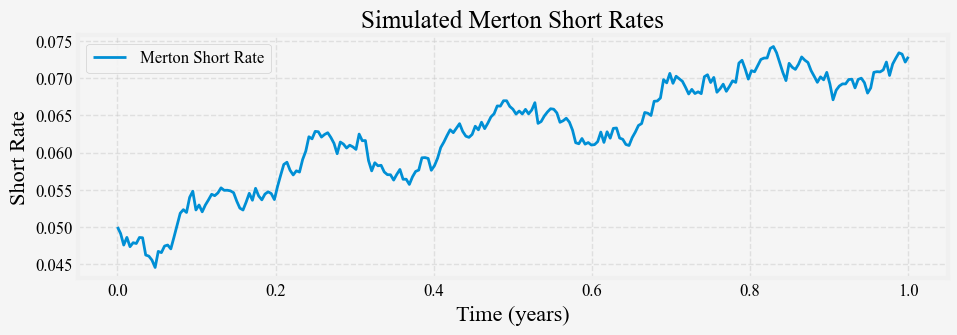

<Figure size 1000x300 with 0 Axes>

In [15]:
plt.plot(*simulated_short_rates, label='Merton Short Rate')
plt.title('Simulated Merton Short Rates')
plt.xlabel('Time (years)')
plt.ylabel('Short Rate')
plt.legend()
plt.show()
plt.tight_layout()

## Bond Prices and Yields from Merton Model

In [22]:
def B(t, T):
    return T - t

def A(t, T, mu, sigma):
    tau = T - t
    return np.exp(-mu * tau**2 / 2 + (sigma**2 * tau**3) / 6)

def zero_coupon_bond_price(t, T, r, mu, sigma):
    return A(t, T, mu, sigma) * np.exp(-B(t, T) * r)

def zero_coupon_yield(t, T, r, mu, sigma):
    price = zero_coupon_bond_price(t, T, r, mu, sigma)
    return -np.log(price) / (T - t)

In [23]:
yield_05 = np.asarray([zero_coupon_yield(0,  5, r, simulate_mu, simulate_sigma) for r in simulated_short_rates[1]])
yield_10 = np.asarray([zero_coupon_yield(0, 10, r, simulate_mu, simulate_sigma) for r in simulated_short_rates[1]])
yield_30 = np.asarray([zero_coupon_yield(0, 30, r, simulate_mu, simulate_sigma) for r in simulated_short_rates[1]])

Given the short rates and the model parameters, we can plot the yields of key zero coupon bonds over time.

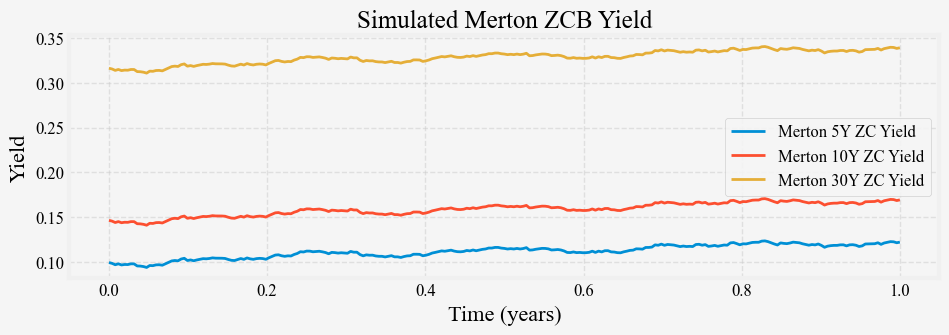

<Figure size 1000x300 with 0 Axes>

In [31]:
plt.plot(simulated_short_rates[0], yield_05, label='Merton 5Y ZC Yield')
plt.plot(simulated_short_rates[0], yield_10, label='Merton 10Y ZC Yield')
plt.plot(simulated_short_rates[0], yield_30, label='Merton 30Y ZC Yield')

plt.title('Simulated Merton ZCB Yield')
plt.xlabel('Time (years)')
plt.ylabel('Yield')
plt.legend()
plt.show()
plt.tight_layout();

We can also vire the term structure by varying the parameters of the model. Below we plot the yield curve using various assumptions for $\mu$ and $\sigma$.

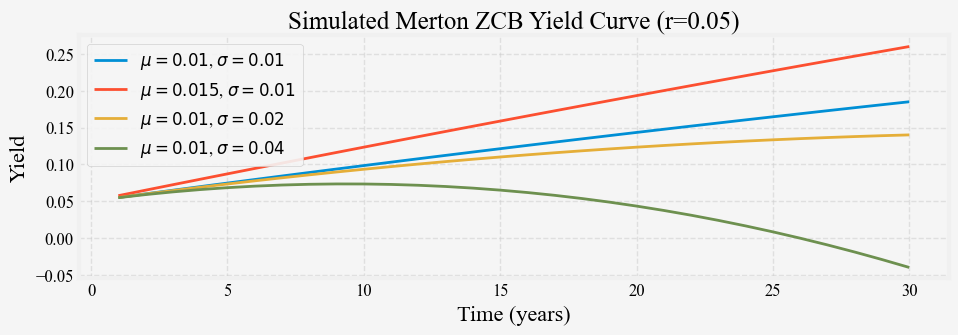

<Figure size 1000x300 with 0 Axes>

In [30]:
tenors = np.arange(1, 31)
plt.plot(tenors, zero_coupon_yield(0, tenors, 0.05, 0.01, 0.01), label="$\mu=0.01$, $\sigma=0.01$")
plt.plot(tenors, zero_coupon_yield(0, tenors, 0.05, 0.015, 0.01), label="$\mu=0.015$, $\sigma=0.01$")
plt.plot(tenors, zero_coupon_yield(0, tenors, 0.05, 0.01, 0.02), label="$\mu=0.01$, $\sigma=0.02$")
plt.plot(tenors, zero_coupon_yield(0, tenors, 0.05, 0.01, 0.04), label="$\mu=0.01$, $\sigma=0.04$")


plt.title('Simulated Merton ZCB Yield Curve (r=0.05)')
plt.xlabel('Time (years)')
plt.ylabel('Yield')
plt.legend()
plt.show()
plt.tight_layout();

## Merton Model Parameter Estimation (under the physical measures)

The calibration of short-rate models can be quite involved in practice depending on what one wants to do. However, to simply fit $\mu4 and $\sigma$ to the market observed short rates, the process is more straightforward. Below we show how to estimate the model parameters of the Merton model from simulated short rates (of the same Merton model) using *Maximumuq likelihood* and *Generalized Method of Moments*.

In [33]:
# Log-likelihood function for Gaussian models
def log_likelihood(params, rates, dt):
    mu, sigma = params
    n = len(rates) - 1
    ll = -0.5 * n * np.log(2 * np.pi * sigma**2 * dt)
    ll -= np.sum((rates[1:] - rates[:-1] - mu * dt)**2) / (2 * sigma**2 * dt)
    return -ll  # Minimize negative log-likelihood

# Maximum Likelihood Estimation
def mle_calibration(rates, dt):
    initial_guess = [0.01, 0.01]  # Initial guess for mu and sigma
    result = minimize(log_likelihood, initial_guess, args=(rates, dt), method='L-BFGS-B')
    return result.x

# Moment conditions for GMM
def moment_conditions(params, rates, dt):
    mu, sigma = params
    delta_r = rates[1:] - rates[:-1]
    m1 = delta_r - mu * dt # first moment (mean)
    m2 = m1**2 - sigma**2 * dt # second moment (variance)
    return np.array([np.mean(m1), np.mean(m2)])

# GMM objective function
def gmm_objective(params, rates, dt, W):
    moments = moment_conditions(params, rates, dt)
    return moments.T @ W @ moments

# Generalized Method of Moments
def gmm_calibration(rates, dt):
    W = np.eye(2)  # Identity weighting matrix for initial estimation
    initial_guess = [0.01, 0.01]  # Initial guess for mu and sigma
    
    # Minimize GMM objective function using Powell's method. The first and second 
    # moments have quite different scales, sp gradient based methods do not work well.
    result = minimize(gmm_objective, initial_guess, args=(rates, dt, W), method='POWELL')
    
    return result.x


Below we fit a Merton model to our simulated short rates using two different methods. For this model they should give the same estimates because the change of short rates follow iid Gaussian distributions.

In [37]:
rates = simulated_short_rates[1]
dt = 1/252

# Calibrate using both methods
mle_mu, mle_sigma = mle_calibration(rates, dt)
gmm_mu, gmm_sigma = gmm_calibration(rates, dt)

print("MLE Calibration:")
print(f"mu: {mle_mu:.6f}, sigma: {mle_sigma:.6f}")
print("\nGMM Calibration:")
print(f"mu: {gmm_mu:.6f}, sigma: {gmm_sigma:.6f}")
print("\nGround Truth:")
print(f"mu: {simulate_mu:.6f}, sigma: {simulate_sigma:.6f}")


MLE Calibration:
mu: 0.022856, sigma: 0.015602

GMM Calibration:
mu: 0.022856, sigma: 0.015602

Ground Truth:
mu: 0.020000, sigma: 0.015000
